In [4]:
import numpy as np
import scipy.sparse
import pandas as pd
pd.set_option("display.max_columns", None)
import time
import datetime
from sklearn import metrics
from scipy.sparse import coo_matrix, csc_matrix, csr_matrix
import tensorflow as tf
import tensorflow as tf
import tensorflow_text
import tensorflow_hub as hub
import tensorflow_transform as tft

from tqdm import tqdm
tqdm.pandas()

In [5]:
from google.cloud import bigquery
import gcsfs

client = bigquery.Client(location="US")
print("Client creating using default project: {}".format(client.project))

Client creating using default project: res-nbcupea-dev-ds-sandbox-001


In [6]:
def focal_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    return tfa.losses.sigmoid_focal_crossentropy(y_true, y_pred, alpha=0.75, gamma=3.0)


In [7]:
# Load the model
model_path = {}
model_path["no_concat"] = "gs://metadata-bucket-base/tfx-metadata-dev-pipeline-output/metadata_dev_edc_base_0_0_6/Trainer/model/24139/serving_model_dir"
#model = tf.saved_model.load(model_path)

In [8]:
# Load the vocab
tags_list_dict = {}
tags_list_dict["no_concat"] = "gs://metadata-bucket-base/tfx-metadata-dev-pipeline-output/metadata_dev_edc_base_0_0_6/Transform/transform_graph/24136/transform_fn/assets/tags"
fs = gcsfs.GCSFileSystem(project="res-nbcupea-dev-ds-sandbox-001")
for key, path in tags_list_dict.items():
    if path == "": continue
    with fs.open(path, "r") as fid:
        tags_list = fid.read().split("\n")
    tags_list = [tag for tag in tags_list if tag != ""]
    tags_list_dict[key] = tags_list
tags_list

['eng',
 'Movie',
 'Su-Su',
 'spa',
 'Episode',
 'New Zealand',
 'Drama',
 'Thrilling',
 'Comedy',
 'Documentary',
 'Action & Adventure',
 'Grandmother',
 '1870s',
 'Thriller',
 'Romance',
 'Science',
 'Sports',
 'Reality',
 'Running away',
 'Adolescent boy',
 'Young love',
 'Equestrian',
 'Transformation',
 'Christianity',
 'Spirit',
 'Comedian',
 'Compassion',
 'Race',
 'Crime',
 "Children's/Family Entertainment",
 'Film',
 'Aviation',
 'Fantasy',
 'Animated',
 'Pervert',
 'Confusion',
 'Mystery',
 'Government offices',
 'Warrior',
 'Poetry',
 'Horror',
 'History',
 'Music',
 'Home',
 'Editor',
 'Science fiction',
 'Insurance investigator',
 'Nihilism',
 'Murder',
 'Sexy woman',
 'Store',
 'Christmas',
 'Palace',
 'Girlfriend',
 'City',
 'Family member',
 'Professionalism',
 'Road',
 'Family',
 'Extortion',
 'Police officer',
 'Richard Nixon',
 'Man',
 'Zombies',
 'Action figure',
 'Football player',
 'Austria',
 'Sex',
 'Director',
 'Medical',
 'Restaurant',
 'White House',
 'Educat

# Evaluation on the content-to-content recommendations

In [10]:
TITLES_QUERY_titles = """
    WITH titles_data AS (
        SELECT DISTINCT
            TitleDetails_title, 
            TitleType, 
            cid.content_ordinal_id,
            STRING_AGG(DISTINCT TitleDetails_longsynopsis, ' ') as TitleDetails_longsynopsis,
        FROM `res-nbcupea-dev-ds-sandbox-001.metadata_enhancement.ContentMetadataView` cmv
        LEFT JOIN `res-nbcupea-dev-ds-sandbox-001.recsystem.ContentOrdinalId` cid
            ON LOWER(cmv.TitleDetails_title) = LOWER(cid.program_title)
        WHERE 
            TitleDetails_longsynopsis IS NOT NULL
            AND cid.content_ordinal_id IS NOT NULL
        GROUP BY 
            TitleDetails_title, 
            TitleType,
            cid.content_ordinal_id
        )
    SELECT TitleDetails_title, LOWER(TitleDetails_title) AS title, TitleType, content_ordinal_id, TitleDetails_longsynopsis, 
    FROM titles_data
"""
df_titles = client.query(TITLES_QUERY_titles) \
                        .to_dataframe() \
                        .drop_duplicates(subset=['TitleDetails_title']) \
                        .reset_index(drop=True)

    
df_titles

,TitleDetails_title,title,TitleType,content_ordinal_id,TitleDetails_longsynopsis
0,End of Days,end of days,Movie,321,An ex-cop (Arnold Schwarzenegger) must protect...
1,Leaving Normal,leaving normal,Movie,511,A cocktail waitress (Christine Lahti) and a ba...
2,Won't You Be My Neighbor?,won't you be my neighbor?,Movie,1185,Filmmaker Morgan Neville examines the life and...
3,House of the Dead,house of the dead,Movie,438,"Party-bound young people (Jonathan Cherry, Tyr..."
4,Harry Potter and the Chamber of Secrets,harry potter and the chamber of secrets,Movie,1455,The young wizard (Daniel Radcliffe) and his be...
...,...,...,...,...,...
2266,Jiffy Pop Airbag,jiffy pop airbag,Programme,1333,This tasty popcorn snack keeps drivers occupie...
2267,Adam Driver End of Summer - Monologue,adam driver end of summer - monologue,Programme,1318,"Host Adam Driver suffers through Aidy Bryant, ..."
2268,Crystal Gravy,crystal gravy,Programme,1325,"A commercial for Crystal Gravy, a new clear gr..."
2269,Ron Swanson Loves Meat,ron swanson loves meat,Programme,1392,Ron Swanson (Nick Offerman) is a man of many m...


In [11]:
input_data = {"synopsis": df_titles['TitleDetails_longsynopsis'].values[:, None], 
              "title": df_titles['TitleDetails_longsynopsis'].values[:, None]}
dataset = tf.data.Dataset.from_tensor_slices(input_data).batch(50)

# Looping over the models
for key, path in model_path.items():
    print(f"Loading model: {key}")
   
    model = tf.saved_model.load(path)
    res = []
    for batch in tqdm(dataset):
        transformed_features = model.tft_layer(batch)
        transformed_features["synopsis"] = transformed_features["synopsis"][:, None]
        y = model(transformed_features)
        res.append(y)
        
    res = list(tf.concat(res, axis=0).numpy())
    df_titles[f"{key}_predicted"] = res
    # Temporarily save the results
    df_titles.to_pickle("./scratch/explore_emd_10_titles_predicted_values.pkl", compression="gzip")

df_titles


Loading model: no_concat


  0%|          | 0/46 [00:00<?, ?it/s]

100%|██████████| 46/46 [02:23<00:00,  3.13s/it]


,TitleDetails_title,title,TitleType,content_ordinal_id,TitleDetails_longsynopsis,no_concat_predicted
0,End of Days,end of days,Movie,321,An ex-cop (Arnold Schwarzenegger) must protect...,"[0.87146485, 0.85619164, 0.40886655, 0.2029905..."
1,Leaving Normal,leaving normal,Movie,511,A cocktail waitress (Christine Lahti) and a ba...,"[0.9445101, 0.7896935, 0.44739848, 0.09543216,..."
2,Won't You Be My Neighbor?,won't you be my neighbor?,Movie,1185,Filmmaker Morgan Neville examines the life and...,"[0.87978995, 0.6192999, 0.50818515, 0.19836688..."
3,House of the Dead,house of the dead,Movie,438,"Party-bound young people (Jonathan Cherry, Tyr...","[0.8756534, 0.84852874, 0.4205134, 0.2083737, ..."
4,Harry Potter and the Chamber of Secrets,harry potter and the chamber of secrets,Movie,1455,The young wizard (Daniel Radcliffe) and his be...,"[0.82229334, 0.83265954, 0.45936924, 0.2412451..."
...,...,...,...,...,...,...
2266,Jiffy Pop Airbag,jiffy pop airbag,Programme,1333,This tasty popcorn snack keeps drivers occupie...,"[0.8998741, 0.5401336, 0.4711439, 0.15523776, ..."
2267,Adam Driver End of Summer - Monologue,adam driver end of summer - monologue,Programme,1318,"Host Adam Driver suffers through Aidy Bryant, ...","[0.9323672, 0.457116, 0.5420614, 0.10295409, 0..."
2268,Crystal Gravy,crystal gravy,Programme,1325,"A commercial for Crystal Gravy, a new clear gr...","[0.95823276, 0.4813727, 0.49308053, 0.08727464..."
2269,Ron Swanson Loves Meat,ron swanson loves meat,Programme,1392,Ron Swanson (Nick Offerman) is a man of many m...,"[0.91380537, 0.7173169, 0.50145066, 0.21177265..."


## Plot the embeddings of some titles

In [17]:
important_titles = ["The Office", "30 Rock", "Punky Brewster", "Parks and Recreation", "WWE Monday Night RAW", 
            "Yellowstone", "Saturday Night Live", "Law & Order: Special Victims Unit", 
            "Law & Order: Organized Crime", "Mr. Mercedes", "Happy Feet Two", "Zombie Tidal Wave"]

key_tags = ["eng", "spa",
            'preschoolers (ages 2-4)', 'kids (ages 5-9)', 'tweens (ages 10-12)','teens (ages 13-14)',
            'older teens (ages 15+)','not for kids',
            "Action & Adventure", "Comedy","Horror", "Children's/Family Entertainment", "Sports", 
            "Animated", "Holiday", "Crime", 'News', 'Reality', 'Music', 'Christmas','Food','Travel','Fantasy',
            'Science fiction','History',
           ]

In [ ]:
df_titles = pd.read_pickle("./scratch/explore_emd_08_titles_predicted_values.pkl", compression="gzip")
df_titles

## Making Content to content recommendations

In [18]:
# Do the pairwise similarity
def cosine_sim(P):
    P = P / np.sqrt(np.sum(P**2, axis=1, keepdims=True))
    cos_sim_c2c = P @ P.T
    cos_sim_c2c = np.nan_to_num(cos_sim_c2c, nan=-1)
    return cos_sim_c2c

def kl_divergence(P):
    P = P / np.sum(P, axis=1, keepdims=True)
    H_p = -np.sum(P * np.log(P), axis=1, keepdims=True)
    H_p_q = -(P @ np.log(P.T))
    D_kl = H_p_q - H_p
    return D_kl

def js_divergence(P):
    D_kl = kl_divergence(P)
    return D_kl * 0.5 + D_kl.T * 0.5

similarity = {"cosine":{}}

for s in similarity:
    for key in model_path.keys():
        predicted = np.stack(df_titles[f"{key}_predicted"].values)
        similarity[s][key] = cosine_sim(predicted)
        
        # Slice out top 15 recommendations
        score = list(np.sort(similarity[s][key], axis=1)[:, ::-1][:, 1:(15+1)])
        sim_c2c_argsort = np.argsort(similarity[s][key], axis=1)[:, ::-1][:, 1:]
        titles = list(np.take(df_titles["TitleDetails_title"].values, sim_c2c_argsort[:, :15]))
        titles_type = list(np.take(df_titles["TitleType"].values, sim_c2c_argsort[:, :15]))
        synopsis = list(np.take(df_titles["TitleDetails_longsynopsis"].values, sim_c2c_argsort[:, :15]))
        content_id = list(np.take(df_titles["content_ordinal_id"].values, sim_c2c_argsort[:, :15]))
        dict_list = [{"TitleDetails_title": tt, "TitleType": ttype, "TitleDetails_longsynopsis": syn, "content_ordinal_id": cid, "score": sc} \
                     for tt, ttype, syn, cid, sc in zip(titles, titles_type, synopsis, content_id, score)]

        df_titles[f"{s}_{key}_top15"] = dict_list
        # Calculate a type match
        df_titles[f"{s}_{key}_type_match"] = (np.stack(titles_type) == df_titles["TitleType"][:, None]).mean(axis=1)
        
df_titles

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:38: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


,TitleDetails_title,title,TitleType,content_ordinal_id,TitleDetails_longsynopsis,no_concat_predicted,cosine_no_concat_top15,cosine_no_concat_type_match
0,End of Days,end of days,Movie,321,An ex-cop (Arnold Schwarzenegger) must protect...,"[0.87146485, 0.85619164, 0.40886655, 0.2029905...","{'TitleDetails_title': ['Push', 'Seed of Chuck...",1.000000
1,Leaving Normal,leaving normal,Movie,511,A cocktail waitress (Christine Lahti) and a ba...,"[0.9445101, 0.7896935, 0.44739848, 0.09543216,...","{'TitleDetails_title': ['Waiting ...', 'Amanda...",1.000000
2,Won't You Be My Neighbor?,won't you be my neighbor?,Movie,1185,Filmmaker Morgan Neville examines the life and...,"[0.87978995, 0.6192999, 0.50818515, 0.19836688...",{'TitleDetails_title': ['Growing Up Black: Fam...,0.733333
3,House of the Dead,house of the dead,Movie,438,"Party-bound young people (Jonathan Cherry, Tyr...","[0.8756534, 0.84852874, 0.4205134, 0.2083737, ...",{'TitleDetails_title': ['The Brides of Dracula...,1.000000
4,Harry Potter and the Chamber of Secrets,harry potter and the chamber of secrets,Movie,1455,The young wizard (Daniel Radcliffe) and his be...,"[0.82229334, 0.83265954, 0.45936924, 0.2412451...",{'TitleDetails_title': ['Harry Potter and the ...,1.000000
...,...,...,...,...,...,...,...,...
2266,Jiffy Pop Airbag,jiffy pop airbag,Programme,1333,This tasty popcorn snack keeps drivers occupie...,"[0.8998741, 0.5401336, 0.4711439, 0.15523776, ...",{'TitleDetails_title': ['The Nerds - Broken Fr...,0.533333
2267,Adam Driver End of Summer - Monologue,adam driver end of summer - monologue,Programme,1318,"Host Adam Driver suffers through Aidy Bryant, ...","[0.9323672, 0.457116, 0.5420614, 0.10295409, 0...",{'TitleDetails_title': ['Affion Crockett: Mirr...,0.400000
2268,Crystal Gravy,crystal gravy,Programme,1325,"A commercial for Crystal Gravy, a new clear gr...","[0.95823276, 0.4813727, 0.49308053, 0.08727464...",{'TitleDetails_title': ['New Chefs on the Bloc...,0.733333
2269,Ron Swanson Loves Meat,ron swanson loves meat,Programme,1392,Ron Swanson (Nick Offerman) is a man of many m...,"[0.91380537, 0.7173169, 0.50145066, 0.21177265...","{'TitleDetails_title': ['We Love You, Sally Ca...",0.133333


## Plotting out the distribution of cosine similarities

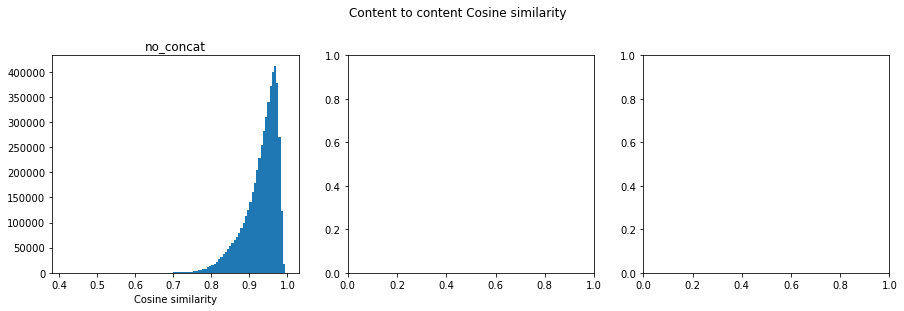

In [19]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
for i, key in enumerate(model_path.keys()):
    ax = axs[i]
    ax.hist(np.sort(similarity["cosine"][key], axis=1)[:, ::-1][:, 1:].ravel(), bins=100) # remove cosine-sim with itself
    ax.set_xlabel("Cosine similarity")
    ax.set_title(key)
    
_ = fig.suptitle("Content to content Cosine similarity", y=1.05)

## Query some shows

In [20]:
# Do some quries
from IPython.display import display
def query_shows_c2c(df_titles, show_name, key="concat_after", sim_metric="cosine", show_res=True):
    pdf = df_titles.loc[df_titles["TitleDetails_title"]==show_name, :]
    pdf_query = pdf[["content_ordinal_id", "TitleDetails_title", "TitleType", "TitleDetails_longsynopsis"]]
    pdf_res = pd.DataFrame(pdf[f"{sim_metric}_{key}_top15"].values[0])
    if show_res:
        print("Query")
        display(pdf_query)
        print(f"Result: {sim_metric} {key}")
        display(pdf_res)
    
    return pdf_query, pdf_res
    

In [ ]:
for ti in important_titles:
    _ = query_shows_c2c(df_titles, ti, key="concat_before")


In [21]:
for ti in important_titles:
    _ = query_shows_c2c(df_titles, ti, key="no_concat")


Query


,content_ordinal_id,TitleDetails_title,TitleType,TitleDetails_longsynopsis
1868,1891,The Office,Programme,An attractive woman's arrival has the male sta...


Result: cosine no_concat


,TitleDetails_title,TitleType,TitleDetails_longsynopsis,content_ordinal_id,score
0,Superstore,Programme,"Amy tries to make Mateo her new assistant, lea...",784,0.993598
1,30 Rock,Programme,Liz must find a way to occupy her time during ...,17,0.992290
2,Everybody Loves Raymond,Programme,Debra can't help but question the solidity of ...,330,0.991114
3,Suits,Programme,"Harvey must work on a case with Louis, but thi...",779,0.990726
4,Cheers,Programme,Carla tricks a man into believing he is the fa...,228,0.990653
5,Southern Charm,Programme,Craig digs into the past to find the source of...,756,0.989936
6,Parks and Recreation,Programme,"Leslie asks Ben, Andy and April to help host a...",626,0.989506
7,Flipping Out,Programme,Highlights from the season. Jeff has to decide...,360,0.989425
8,The King of Queens,Programme,Doug Heffernan shares a house with his wife an...,880,0.989259
9,Roseanne,Programme,Dan enters a songwriting contest with Roseanne...,1341,0.989157


Query


,content_ordinal_id,TitleDetails_title,TitleType,TitleDetails_longsynopsis
1758,17,30 Rock,Programme,Liz must find a way to occupy her time during ...


Result: cosine no_concat


,TitleDetails_title,TitleType,TitleDetails_longsynopsis,content_ordinal_id,score
0,Vanderpump Rules,Programme,Lisa has her staff help create a parade float ...,1315,0.993425
1,Cheers,Programme,Carla tricks a man into believing he is the fa...,228,0.993076
2,Southern Charm,Programme,Craig digs into the past to find the source of...,756,0.992676
3,Superstore,Programme,"Amy tries to make Mateo her new assistant, lea...",784,0.992540
4,Chrisley Knows Best,Programme,Todd wants Chase and Savannah to learn the val...,236,0.992536
5,The Game,Programme,Derwin invites Melanie to his first away game ...,1076,0.992373
6,The Office,Programme,An attractive woman's arrival has the male sta...,1891,0.992290
7,The King of Queens,Programme,Doug Heffernan shares a house with his wife an...,880,0.991827
8,Modern Family,Programme,Claire and Phil each take on one of the kids' ...,2036,0.991637
9,Frasier,Programme,A sick Frasier begs Niles to be the substitute...,371,0.991486


Query


,content_ordinal_id,TitleDetails_title,TitleType,TitleDetails_longsynopsis
1862,656,Punky Brewster,Programme,Punky makes a date with two boys for the same ...


Result: cosine no_concat


,TitleDetails_title,TitleType,TitleDetails_longsynopsis,content_ordinal_id,score
0,Zoey's Extraordinary Playlist,Programme,"Zoey, an introverted computer programmer livin...",1022,0.988230
1,Father Knows Best,Programme,After Bud gets a summons to appear at the poli...,1914,0.987678
2,Everybody Hates Chris,Programme,"After deciding to buy a leather jacket, Chris ...",1044,0.987232
3,Saved by the Bell,Programme,A student argument helps a teacher resolve a p...,695,0.986766
4,Odd Mom Out,Programme,"Jill reluctantly throws a ""sip `n' see"" party ...",1717,0.985862
5,Will & Grace,Programme,"Will, Grace, Karen and Jack wish they could ha...",1011,0.984698
6,Stone Age,Programme,Eavesdropping is the name of the game today fo...,1142,0.984177
7,The Munsters,Programme,Lily and Herman take part-time jobs to buy eac...,902,0.983982
8,Sweet Home Oklahoma,Programme,Jen and Josh take their boys to stay with Jen'...,788,0.983953
9,Nina's World,Programme,Mami and Papi go on a weekend trip and Nina an...,1423,0.983940


Query


,content_ordinal_id,TitleDetails_title,TitleType,TitleDetails_longsynopsis
1986,626,Parks and Recreation,Programme,"Leslie asks Ben, Andy and April to help host a..."


Result: cosine no_concat


,TitleDetails_title,TitleType,TitleDetails_longsynopsis,content_ordinal_id,score
0,Chrisley Knows Best,Programme,Todd wants Chase and Savannah to learn the val...,236,0.992598
1,George Lopez,Programme,Angie plans a surprise birthday party for Geor...,379,0.992057
2,Superstore,Programme,"Amy tries to make Mateo her new assistant, lea...",784,0.991623
3,30 Rock,Programme,Liz must find a way to occupy her time during ...,17,0.990766
4,Southern Charm,Programme,Craig digs into the past to find the source of...,756,0.990708
5,The Office,Programme,An attractive woman's arrival has the male sta...,1891,0.989506
6,The King of Queens,Programme,Doug Heffernan shares a house with his wife an...,880,0.989468
7,The Game,Programme,Derwin invites Melanie to his first away game ...,1076,0.989464
8,Modern Family,Programme,Claire and Phil each take on one of the kids' ...,2036,0.989257
9,Everybody Hates Chris,Programme,"After deciding to buy a leather jacket, Chris ...",1044,0.989197


Query


,content_ordinal_id,TitleDetails_title,TitleType,TitleDetails_longsynopsis
2049,2301,WWE Monday Night RAW,Programme,The Undertaker vs. Isaac Yankem. Ultimate Warr...


Result: cosine no_concat


,TitleDetails_title,TitleType,TitleDetails_longsynopsis,content_ordinal_id,score
0,WWE NXT,Programme,No Way Jose vs. Killian Dain. The NXT Champion...,2341,0.942594
1,WWE Friday Night SmackDown,Programme,"The 2019 WWE Draft kicks off; Seth Rollins, re...",2292,0.917073
2,The Best of WWE,Programme,The best matches in history of the World Wrest...,1209,0.902840
3,WrestleMania,Programme,The historic first WrestleMania from Madison S...,2295,0.888672
4,Royal Rumble,Programme,Twenty Superstars compete in the first-ever Ro...,2294,0.876189
5,WrestleMania Rewind,Programme,"It's 1987, and Hulkamania is running wild. Rew...",1211,0.854953
6,WWE The Bump,Programme,Goldberg previews his WWE Championship match a...,2363,0.843570
7,American Ninja Warrior,Programme,"After his town is destroyed by a tornado, Jeff...",89,0.835898
8,The Voice,Programme,The battle rounds begin as the coaches enlist ...,1594,0.827945
9,Hollywood Game Night,Programme,Contestants play party games with celebrities ...,428,0.822884


Query


,content_ordinal_id,TitleDetails_title,TitleType,TitleDetails_longsynopsis
1809,1017,Yellowstone,Programme,The Duttons gear up for a final fight with the...


Result: cosine no_concat


,TitleDetails_title,TitleType,TitleDetails_longsynopsis,content_ordinal_id,score
0,Hitmen,Programme,Fran and Jamie are ordered to extract informat...,1189,0.986846
1,Ray Donovan,Programme,Mickey spends time with Bunchy and Terry; Ray ...,1064,0.986540
2,CONNECTING...,Programme,As the group gears up to attend a Black Lives ...,1537,0.986412
3,The Jeff Foxworthy Show,Programme,Observations by the blue-collar owner (Jeff Fo...,874,0.986030
4,Covert Affairs,Programme,Annie and McQuaid join forces to escape Venezu...,262,0.985970
5,The Wall,Programme,Teams of two everyday people battle trivia que...,944,0.985910
6,Very Cavallari,Programme,"Kristin travels to Los Angeles to co-host ""E! ...",987,0.985013
7,Sunnyside,Programme,"Garrett and the gang race all over the city, d...",783,0.984619
8,Consumed: The Real Restaurant Business,Programme,Trend-setting chain The Meatball Shop looks to...,256,0.984146
9,Blindspot,Programme,The team races against the clock to save one o...,176,0.983981


Query


,content_ordinal_id,TitleDetails_title,TitleType,TitleDetails_longsynopsis
1579,693,Saturday Night Live,Programme,Talented actors and comedians who are accompan...


Result: cosine no_concat


,TitleDetails_title,TitleType,TitleDetails_longsynopsis,content_ordinal_id,score
0,The Tonight Show Starring Jimmy Fallon,Programme,Actor Jesse Eisenberg; actress Hailee Steinfel...,936,0.770634
1,A Little Late With Lilly Singh,Programme,Actress Stephanie Beatriz. Actress Awkwafina. ...,32,0.753206
2,It's Showtime at the Apollo,Programme,Stephanie Mills; Phoebe Snow; Yaphet Kotto; co...,2084,0.747860
3,Johnny Carson,Programme,Actor Buddy Hackett; Dave Thomas; actress Tere...,473,0.738067
4,Jimmy announces BTS week,Programme,Jimmy announces a week of special BTS performa...,1418,0.736888
5,Celebrating Latinas in music,Programme,"On the September 22nd edition of ""E! Pop on Pe...",1363,0.735192
6,The Carol Burnett Show,Programme,Guests: Tim Conway and Shani Wallis. Carol Bur...,817,0.722016
7,The At-Home Variety Show Featuring Seth MacFar...,Programme,Masterclass: Action in Quarantine; Kate and Jo...,804,0.721497
8,The National Dog Show,Movie,"Over 2,000 purebred dogs vie to be named Best ...",1736,0.715513
9,Best Fails of the Month,Programme,The best of the worst for December 2018. The b...,1899,0.709599


Query


,content_ordinal_id,TitleDetails_title,TitleType,TitleDetails_longsynopsis
2127,506,Law & Order: Special Victims Unit,Programme,A woman claims that Brian Cassidy (Dean Winter...


Result: cosine no_concat


,TitleDetails_title,TitleType,TitleDetails_longsynopsis,content_ordinal_id,score
0,Snapped,Programme,An Air Force sergeant is gunned down in his ga...,744,0.986911
1,Forensic Files,Programme,After a wealthy Southern physician gets murder...,365,0.985786
2,Dateline NBC,Programme,"A look at the case of con man John Meehan, inc...",272,0.984171
3,Law & Order: Criminal Intent,Programme,The philandering wife of an arrogant plastic s...,505,0.982555
4,Law & Order,Programme,"After a bloody massacre of heroin dealers, Fon...",504,0.981840
5,"Murder, She Wrote",Programme,The pervasive stench of death looms over Jessi...,586,0.981776
6,Dateline,Programme,The murder of a California mother beloved by f...,271,0.980028
7,Chicago P.D.,Programme,A decapitated corpse found in Lake Michigan is...,232,0.973929
8,Hunter,Programme,A parole officer's murder leads to an ex-convi...,443,0.970329
9,Monk,Programme,"Lt. Disher inherits his uncle's farm, but susp...",573,0.969260


Query


,content_ordinal_id,TitleDetails_title,TitleType,TitleDetails_longsynopsis
2257,2325,Law & Order: Organized Crime,Programme,Elliot Stabler returns to the NYPD to take on ...


Result: cosine no_concat


,TitleDetails_title,TitleType,TitleDetails_longsynopsis,content_ordinal_id,score
0,The Black Dahlia,Movie,"In 1940s Los Angeles two cops (Josh Hartnett, ...",810,0.989967
1,The Public,Movie,An act of civil disobedience turns into a stan...,1286,0.989625
2,Checkmate,Movie,The lives of six people collide during an elab...,227,0.989195
3,Corbin Nash,Movie,A New York City cop transfers to Los Angeles t...,259,0.988917
4,Anthony,Movie,"In July 2005, Black teenager Anthony Walker is...",1270,0.988543
5,Daylight,Movie,An ex-EMS chief (Sylvester Stallone) leads the...,2136,0.988423
6,Rampart,Movie,A veteran cop (Woody Harrelson) blurs the line...,661,0.988256
7,Police Academy,Movie,The new mayor's policy puts badges on misfits:...,1650,0.987728
8,Scarface,Movie,"Despite warnings from crime boss Johnny Lovo, ...",705,0.987456
9,Burn After Reading,Movie,Chaos reigns when a gym employee (Frances McDo...,1927,0.987293


Query


,content_ordinal_id,TitleDetails_title,TitleType,TitleDetails_longsynopsis
1905,1562,Mr. Mercedes,Programme,Ida is hurt as Hodges and Janey grow closer; L...


Result: cosine no_concat


,TitleDetails_title,TitleType,TitleDetails_longsynopsis,content_ordinal_id,score
0,Manifest,Programme,Ben forms an alliance with a student from Flig...,540,0.986550
1,Ray Donovan,Programme,Mickey spends time with Bunchy and Terry; Ray ...,1064,0.984603
2,The Affair,Programme,"Since she is distracted by her business, Helen...",1072,0.983770
3,Blindspot,Programme,The team races against the clock to save one o...,176,0.983076
4,Sunnyside,Programme,"Garrett and the gang race all over the city, d...",783,0.982989
5,Necessary Roughness,Programme,New management at the Hawks turns Dani's world...,594,0.982926
6,Bluff City Law,Programme,Elijah and Sydney help a Catholic teacher who ...,183,0.981992
7,Bad Girls Club: Twisted Sisters,Programme,Jazmyn and Jaimee stick together against the r...,129,0.981928
8,CONNECTING...,Programme,As the group gears up to attend a Black Lives ...,1537,0.981891
9,Yellowstone,Programme,The Duttons gear up for a final fight with the...,1017,0.981476


Query


,content_ordinal_id,TitleDetails_title,TitleType,TitleDetails_longsynopsis
1116,2320,Happy Feet Two,Movie,"Reluctant to dance, the son of Mumble (Elijah ..."


Result: cosine no_concat


,TitleDetails_title,TitleType,TitleDetails_longsynopsis,content_ordinal_id,score
0,Morphle,Programme,Little Mila turns playtime into fun and educat...,2337,0.989149
1,Santa and the Three Bears,Movie,A mother bear is helped by a ranger when her m...,2362,0.988872
2,Barbie & Her Sisters in The Great Puppy Adventure,Movie,"Barbie, her sisters and their new puppy friend...",1436,0.988314
3,Princess and the Pony,Movie,A young princess (Fiona Perry) travels to Amer...,651,0.988250
4,Curious George 2: Follow That Monkey,Movie,George embarks on a cross-country trip to reun...,1582,0.987791
5,Barney's Great Adventure,Movie,"The big, purple dinosaur and his young friends...",136,0.987156
6,The Life & Adventures of Santa Claus,Movie,"Fairies adopt an orphaned human baby, who grow...",1226,0.985506
7,Bilby,Movie,Bilby becomes an unwilling protector to a baby...,1110,0.985381
8,Happy Feet,Movie,"Born without the ability to sing, a young empe...",2319,0.984847
9,The Land Before Time,Movie,An orphaned dinosaur and his new friends face ...,1966,0.984626


Query


,content_ordinal_id,TitleDetails_title,TitleType,TitleDetails_longsynopsis
704,1574,Zombie Tidal Wave,Movie,Zombies wreak bloodthirsty havoc after a tidal...


Result: cosine no_concat


,TitleDetails_title,TitleType,TitleDetails_longsynopsis,content_ordinal_id,score
0,Neverknock,Movie,After Grace and her friends ignore the warning...,1564,0.985998
1,Leprechaun 3,Movie,The diminutive demon meets his match when a co...,2244,0.985102
2,The Haunting of Whaley House,Movie,Terror awaits amateur ghost-hunters when they ...,857,0.984907
3,Zoombies,Movie,A mysterious virus turns animals at a safari p...,1024,0.984824
4,"Monster High: Frights, Camera, Action!",Movie,Draculaura and her ghoulish friends must locat...,1118,0.983095
5,Open Grave,Movie,A man awakes-- without memory -- in a pit full...,1764,0.980031
6,Monster High: Welcome to Monster High,Movie,Draculaura and her ghoulfriends travel the wor...,1546,0.979860
7,Van Helsing: The London Assignment,Movie,The famous monster hunter travels to London to...,1572,0.978518
8,Leprechaun: Back 2 tha Hood,Movie,A young woman and her friends incur the wrath ...,2246,0.978119
9,Monster High: Freaky Fusion,Movie,"During the Bite-Centennial, the ghouls travel ...",1117,0.977940


In [ ]:
for ti in important_titles:
    _ = query_shows_c2c(df_titles, ti, key="concat_after")


In [ ]:
_ = query_shows_c2c(df_titles, "The Office", key="concat_before")

In [32]:
print(df_titles.head()[["title", "content_ordinal_id"]].to_string())

                                     title  content_ordinal_id
0                              end of days                 321
1                           leaving normal                 511
2                won't you be my neighbor?                1185
3                        house of the dead                 438
4  harry potter and the chamber of secrets                1455
